## Trabajo práctico 1: Bayes Ingenuo
---
*Estudiantes:* 
- Dennis Luna
- Graciela Rivera
- Luis E. Vargas 
---

## *I Sección: Implementación de la clasificación multi-clase con Bayes ingenuo*

### Librerías

In [17]:
import re
import torch
import torchvision
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from scipy.stats import multivariate_normal as mvn

### 1. Carga de las imágenes- mnist_dataset

In [42]:

def binarize_image(image_tensor):
    image_tensor[image_tensor > 0.5] = 1
    image_tensor[image_tensor <= 0.5] = 0
    return image_tensor

def imshow(image_tensor):
    im = plt.imshow(image_tensor.numpy(), cmap = 'gray')
    plt.show()
       
def load_single_image(path = "src_base/mnist_dataset/train", img_index=1, mode="bin"):
    #Open up the dataset
    dataset =  torchvision.datasets.ImageFolder(path)   
    #print(dataset)
    list_images = dataset.imgs
    pair_path_label = list_images[img_index]
    new_image = Image.open(pair_path_label[0]) 
    new_image_plain = None
    
    if(mode == "bin"):
        new_image_tf = TF.to_tensor(new_image).squeeze() #Return tensor in range [0.0 - 1.0]
        new_image_bin = binarize_image(new_image_tf)
        new_image_plain = new_image_bin.view(new_image_bin.shape[0] * new_image_bin.shape[1])
    elif(mode == "gray"):
        new_image_gray = TF.pil_to_tensor(new_image).squeeze() #Return tensor in grayscale
        new_image_plain = new_image_gray.view(new_image_gray.shape[0] * new_image_gray.shape[1])
    else:
        print("\n-E- Modo seleccionado invalido\n")
        
    return(new_image_plain)
        
def load_dataset(path = "src_base/mnist_dataset/train"):
    #Open up the dataset
    dataset =  torchvision.datasets.ImageFolder(path)   
    #print(dataset)
    list_images = dataset.imgs
    #print(list_images)
    train_data_tensor_bin  = None 
    train_data_tensor_gray = None
    labels_training = []
    images_indexes = []
    first_tensor = True
    #list_images_training =  set(data_labeled.train_ds.x.items)
    #print(list_images)
    for i in range(len(list_images)):
        pair_path_label = list_images[i]
        image = Image.open(pair_path_label[0])
        m = re.search(r'img_(\d+)\.', pair_path_label[0])
        images_indexes.append(int(m.group(1)))
        
        x_tensor = TF.to_tensor(image).squeeze() #Return tensor in range [0.0 - 1.0]
        x_tensor_gray = TF.pil_to_tensor(image).squeeze() #Return tensor in grayscale
        x_tensor_bin = binarize_image(x_tensor)
               
        #plt.figure()
        #plt.imshow(x_tensor_bin)
        x_tensor_bin_plain = x_tensor_bin.view(x_tensor_bin.shape[0] * x_tensor_bin.shape[1], -1)
        x_tensor_gray_plain = x_tensor_gray.view(x_tensor_gray.shape[0] * x_tensor_gray.shape[1], -1)
        #print("tensor ", x_tensor_bin_plain)
        #test dataset case        
        #if("train" in pair_path_label[0]):
        labels_training += [pair_path_label[1]]
        #print(pair_path_label)
        if(first_tensor):
            first_tensor = False
            train_data_tensor_bin = x_tensor_bin_plain
            train_data_tensor_gray = x_tensor_gray_plain
        else:
            train_data_tensor_bin = torch.cat((train_data_tensor_bin, x_tensor_bin_plain), 1)  
            train_data_tensor_gray = torch.cat((train_data_tensor_gray, x_tensor_gray_plain), 1)
    return (train_data_tensor_bin, train_data_tensor_gray, torch.tensor(labels_training), torch.tensor(images_indexes))       

(train_data_tensor_bin, train_data_tensor_gray, labels_training, images_indexes) = load_dataset()

print("train gray dimensions", train_data_tensor_gray.shape)
print("train bin dimensions ", train_data_tensor_bin.shape)
print("train labels ", len(labels_training))
print("images indexes ", len(images_indexes))

train gray dimensions torch.Size([784, 600])
train bin dimensions  torch.Size([784, 600])
train labels  600
images indexes  600


### 2. Train Model Enfoque Paramétrico

In [3]:
def evaluate_gaussian(mu, sigma, x):
    coef_norm = 1 / (torch.sqrt(2.0 * torch.pi * sigma ** 2))
    return coef_norm * torch.exp(-0.5*((x - mu)/sigma)**2)

def evaluate_gaussian_log(mu, sigma, x_tensor):
    M = x_tensor.shape[1]
    summation = -1 / (2.0 * torch.pi * sigma ** 2) * ((x_tensor - mu) ** 2).sum(dim=1).view(x_tensor.shape[0], -1)
    p_gaussian = summation - (M/2 * torch.log(torch.tensor(2 * torch.pi))) - (M * torch.log(sigma))
    return p_gaussian
    
def train_model(train_data_tensor_bin, train_data_tensor_gray, labels_bin, labels_gray, num_classes = 10):

    first_tensor = True
    p_t_tensor_acc = None
    p_m_1_given_k_acc = None
    p_m_0_given_k_acc = None
    mu_given_k_acc = None
    sigma_given_k_acc = None
    
    for k in range(num_classes):
        # Filtra train_data_tensor por clase para dataset binarizado y en escala de grises
        train_data_tensor_bin_per_k = train_data_tensor_bin[:, labels_bin == k].type(torch.int64)
        train_data_tensor_gray_per_k = train_data_tensor_gray[:, labels_gray == k].type(torch.float64)

        # D = cantidad de filas (784 pixeles)
        # N = cantidad de columnas (600 imágenes)
        D, N = train_data_tensor_bin.shape
        
        # Estimacion de probabilidad a priori
        p_t_tensor = torch.tensor([train_data_tensor_bin_per_k.shape[1] / N])
        
        # Estimacion de verosimilitud para cada pixel por clase
        p_m_1_given_k = ((train_data_tensor_bin_per_k == 1).sum(dim=1)/train_data_tensor_bin_per_k.shape[1])+1e-12
        
        # Transforma tensor de verosimilitud a una sola columna
        p_m_1_given_k = p_m_1_given_k.view(p_m_1_given_k.shape[0], -1)
     
        # Calculo de media y desviacion estandar
        mu_given_k = torch.mean(train_data_tensor_gray_per_k, dim=1)
        sigma_given_k = torch.var(train_data_tensor_gray_per_k, dim=1)+1e-12
    
        # Transforma tensor de mu y sigma a una sola columna
        mu_given_k = mu_given_k.view(mu_given_k.shape[0], -1)
        sigma_given_k = sigma_given_k.view(sigma_given_k.shape[0], -1)
      
        # Estimacion de funcion de densidad de probabilidad
        if(first_tensor):
            first_tensor = False
            p_m_1_given_k_acc = p_m_1_given_k
            p_t_tensor_acc = p_t_tensor
            mu_given_k_acc = mu_given_k
            sigma_given_k_acc = sigma_given_k
            #gaussian_given_k_acc = gaussian_given_k
        else:
            p_m_1_given_k_acc = torch.cat((p_m_1_given_k_acc, p_m_1_given_k), 1)
            p_t_tensor_acc = torch.cat((p_t_tensor_acc, p_t_tensor), 0)
            mu_given_k_acc = torch.cat((mu_given_k_acc, mu_given_k), 1)
            sigma_given_k_acc = torch.cat((sigma_given_k_acc, sigma_given_k), 1)
            #gaussian_given_k_acc = torch.cat((gaussian_given_k_acc, gaussian_given_k), 1)

    # Saca complemento de p_m_1_given_k_acc
    p_m_0_given_k_acc = 1 - p_m_1_given_k_acc
        
    return (list([p_m_0_given_k_acc, p_m_1_given_k_acc]), mu_given_k_acc, sigma_given_k_acc, p_t_tensor_acc)
            
#px,mu_given_k_acc,sigma_given_k_acc,p_t_tensor_acc =
train_model(train_data_tensor_bin, train_data_tensor_gray, labels_training, labels_training, 10)

([tensor([[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]),
  tensor([[1.0000e-12, 1.0000e-12, 1.0000e-12,  ..., 1.0000e-12, 1.0000e-12,
           1.0000e-12],
          [1.0000e-12, 1.0000e-12, 1.0000e-12,  ..., 1.0000e-12, 1.0000e-12,
           1.0000e-12],
          [1.0000e-12, 1.0000e-12, 1.0000e-12,  ..., 1.0000e-12, 1.0000e-12,
           1.0000e-12],
          ...,
          [1.0000e-12, 1.0000e-12, 1.0000e-12,  ..., 1.0000e-12, 1.0000e-12,
           1.0000e-12],
          [1.0000e-12, 1.0000e-12, 1.0000e-12,  ..., 1.0000e-12, 1.0000e-12,
           1.0000e-12],
          [1.0000e-12, 1.0000e-12, 1.0000e-12,  ..., 1.0000e-12, 1.0000e-12,
           1.0000e-12]])],
 tensor([[0.1667, 0.0667, 0.3667,  ..., 0.3167, 0.2667, 0.0000],
         [0.4000, 0.0333, 0.4333,  ..., 0.

### 2.1 Train Model Enfoque Basado en Histogramas

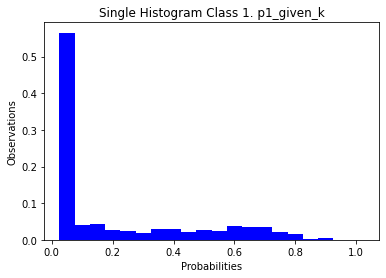

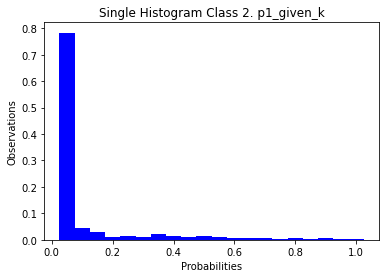

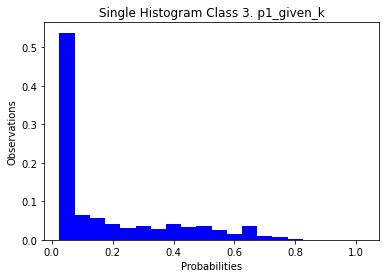

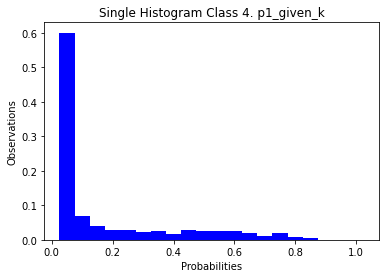

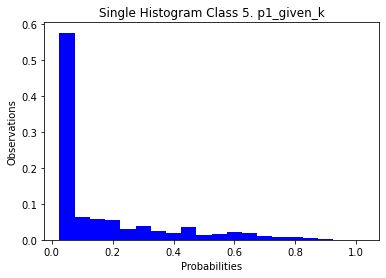

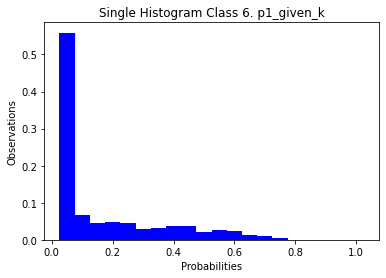

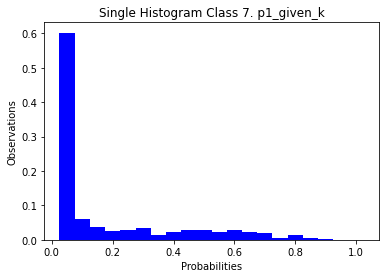

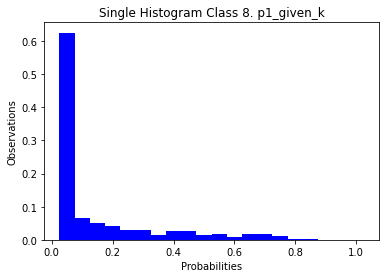

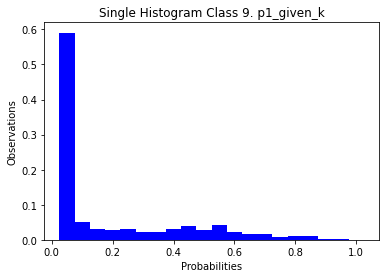

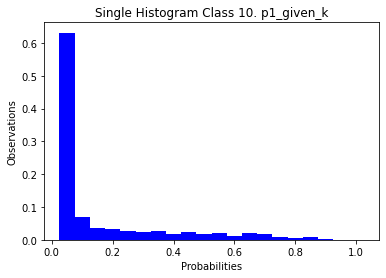

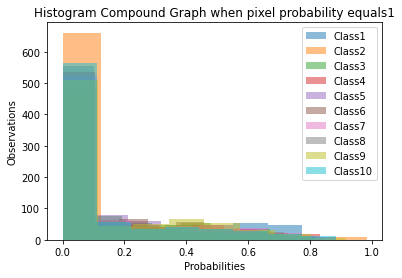

In [4]:
def histogram_approach_Compound_graph(p_m_pix_val_given_k,bin_type,case):
    
    n_bins = 8
    num_clases=10
    
    for k in range(num_clases):
        #calculate histogram
        #histogram, bins = np.histogram(p_m_pix_val_given_k[bin_type][:,k].numpy(), bins = 20, range = (0, 1))
        name_label='Class' + str(k+1)
        
        plt.hist(p_m_pix_val_given_k[bin_type][:,k].numpy(),n_bins,alpha=0.5,label=name_label)
        plt.title('Histogram Compound Graph when pixel probability equals' + case)
        plt.xlabel('Probabilities')
        plt.ylabel('Observations')
        
        if bin_type==0:
            plt.legend(loc='upper left')
        else:
            plt.legend(loc='upper right')
            
    #plt.savefig("CompoundPlot"+case+".svg")   
            
def histogram_approach_graph(p_m_pix_val_given_k,bin_type,case):
    
    num_clases=10
    
    for k in range(num_clases):
        #calculate histogram
        histogram, bins = np.histogram(p_m_pix_val_given_k[bin_type][:,k].numpy(), bins = 20, range = (0, 1))
        
        name_label='Class' + str(k)
        
        #plt.hist(p_m_pix_val_given_k[bin_type][:,k].numpy(),n_bins,alpha=0.5)
        
        p_1 = torch.tensor(histogram / histogram.sum())
        p_1 = p_1.numpy()
        #plot single histogram
        
        #calculate the width of the histogram bins displayed
        width = np.max(bins[1:]) / bins[1:].shape[0]
        #print("Width: ", width)
        plt.bar(bins[1:].tolist(), p_1.tolist(), color ='blue', width = width)
        plt.xlabel("Probabilities")
        plt.ylabel("Observations")
        plt.title("Single Histogram Class "+str(k+1)+". p"+case+"_given_k")
        #plt.savefig("Case_plot_"+case+"_%s.svg"%(k+1))
        plt.show()
        
        
p_m_pix_val_given_k, mu_all, sigma_all, p_t_tensor = train_model(train_data_tensor_bin, train_data_tensor_gray, labels_training, labels_training)       

histogram_approach_graph(p_m_pix_val_given_k,bin_type=1,case='1')
histogram_approach_Compound_graph(p_m_pix_val_given_k,bin_type=1,case='1')

### 3. Test Bernoulli Model Function

In [5]:
def test_model_bernoulli(input_torch, p_m_pix_val_given_k, p_t_tensor, num_classes = 10):
    #assumes that the input comes in a row    
    input_torch_single_column = input_torch.view(input_torch.shape[0], -1)
    
    p_t_k_given_m = [] 
    for k in range(num_classes):
        # Extraer probabilidades de acuerdo al input_torch nuevo para cuando pixel es 0
        #print(p_m_pix_val_given_k[0][:,k].shape)
        #print(p_m_pix_val_given_k[0][:,k].unsqueeze(dim=1).shape)
        #print(input_torch_single_column.shape)
        p_m_0_extracted = torch.log(p_m_pix_val_given_k[0][:,k].unsqueeze(dim=1)[input_torch_single_column == 0])
        #p_m_0_extracted = torch.log(p_m_pix_val_given_k[0][:,k][input_torch[k,:] == 0])
        # Estima log para todas las probabilidades extraidas
        p_m_0_estimated = p_m_0_extracted.sum(dim=0) 
        # Extraer probabilidades de acuerdo al input_torch nuevo para cuando pixel es 1
        p_m_1_extracted = torch.log(p_m_pix_val_given_k[1][:,k].unsqueeze(dim=1)[input_torch_single_column == 1])
        #p_m_1_extracted = torch.log(p_m_pix_val_given_k[1][:,k][input_torch[k,:] == 1])
        # Estima log para todas las probabilidades extraidas
        p_m_1_estimated = p_m_1_extracted.sum(dim=0) 
        # Estimacion de la probabilidad posterior
        p_t_k_given_m.append(p_m_0_estimated + p_m_1_estimated + torch.log(p_t_tensor[k]))
        
    scores_classes = p_t_k_given_m
    #predicted_label = max(p_t_k_given_m)
    predicted_label = scores_classes.index(max(scores_classes))
    return (predicted_label, scores_classes)#ocupo retorna la clase 

new_image_ber = load_single_image(img_index = 65, mode="bin") #Numero 1
test_model_bernoulli(new_image_ber, p_m_pix_val_given_k, p_t_tensor, num_classes = 10)

    


(1,
 [tensor(-453.0000),
  tensor(-71.3250),
  tensor(-174.6764),
  tensor(-181.1103),
  tensor(-276.7626),
  tensor(-163.3922),
  tensor(-188.7553),
  tensor(-227.8077),
  tensor(-167.0967),
  tensor(-226.6600)])

### 4. Test Gaussian Model Function

In [6]:
def test_model_gaussian(input_torch, mu, sigma, p_t_tensor, num_classes = 10):
    #assumes that the input comes in a row
    #input_torch_reshaped = input_torch.view(input_torch.shape[0], -1)
    #print(input_torch_reshaped.shape)
    
    # Estimacion de la probabilidad de verisimilitud para todas las clases
    #p_gaussian_estimated = evaluate_gaussian(mu, sigma, input_torch_reshaped)+1e-12
    #print(p_gaussian_estimated.shape)

    p_posterior_all = []
    for k in range(num_classes):
        # Estimacion de la probabilidad posterior
        mu_row = mu[:,k].reshape(1, mu.shape[0]).squeeze()
        sigma_row = sigma[:,k].reshape(1, sigma.shape[0]).squeeze()
        p_gaussian_estimated = mvn.logpdf(input_torch, mean=mu_row, cov=sigma_row, allow_singular=True) + torch.log(p_t_tensor[k])
        p_posterior_all.append(p_gaussian_estimated)
        #p_posterior_all.append(p_gaussian_estimated[:, k].sum(dim=0) + torch.log(p_t_tensor[k]))
        
    scores_classes = p_posterior_all
    predicted_label = scores_classes.index(max(scores_classes))
    #predicted_label = max(scores_classes)
       
    return(predicted_label, scores_classes)

new_image_gaus = load_single_image(img_index = 65, mode="gray") #Numero 1

test_model_gaussian(new_image_gaus, mu_all, sigma_all, p_t_tensor, num_classes = 10)

(1,
 [tensor(-10234.3125),
  tensor(-1882.2296),
  tensor(-2931.0232),
  tensor(-2997.3086),
  tensor(-5552.8481),
  tensor(-2899.3098),
  tensor(-2730.3958),
  tensor(-5943.7979),
  tensor(-2861.8804),
  tensor(-5870.3726)])

### 6.Test Bernoulli Model batch Function: Accuracy

In [7]:
def test_Bernoulli_model_batch(test_set, labels, p_m_pix_val_given_k, p_t_tensor):
    
    number_observations = test_set.shape[0]
    number_correct_predictions = 0
    for observation_id in range(number_observations):
        current_observation = test_set[observation_id]
        predicted_label,scores_classes = test_model_bernoulli(current_observation, p_m_pix_val_given_k, p_t_tensor, num_classes = 10)
        if (predicted_label == labels[observation_id]): #poner la clase label= clase 
            number_correct_predictions += 1

    accuracy = number_correct_predictions/number_observations
    #print(accuracy)
    return accuracy


### 5.Test Gaussian Model batch Function: Accuracy

In [8]:
def test_Gaussian_model_batch(test_set, labels, mu_tensor, sigma_tensor, p_t_tensor):
    
    number_observations = test_set.shape[0]
    number_correct_predictions = 0
    for observation_id in range(number_observations):
        current_observation = test_set[observation_id]
        predicted_label,scores_classes = test_model_gaussian(current_observation, mu_tensor, sigma_tensor, p_t_tensor, num_classes = 10)
        if (predicted_label == labels[observation_id]): #poner la clase label= clase 
            number_correct_predictions += 1

    accuracy = number_correct_predictions/number_observations
    #print(accuracy)
    return accuracy


## *A|B Testing*

### 1.Create partitions with 80% dataset for Train Model and 20% dataset for Test Model (Stratify)

In [97]:
#Changed images_indexes tensor to a singular column
images_indexes_col = images_indexes.view(images_indexes.shape[0], -1)

#Transposed dimensions to be processed by train_test_split from [784,600] to [600,784]
dataset_bin = torch.transpose(train_data_tensor_bin, 0, 1)
dataset_gray = torch.transpose(train_data_tensor_gray, 0, 1)
#print(dataset_bin.shape, labels_training.shape)

#Added images indexes to the dataset before partioning
dataset_bin = torch.cat((dataset_bin,images_indexes_col), 1)
dataset_gray = torch.cat((dataset_gray,images_indexes_col), 1)

# Creando particiones 80% Training y 20% Testing para el set de datos
features_train_bin, features_test_bin, label_train_bin, label_test_bin = train_test_split(dataset_bin, labels_training, test_size=0.2, random_state=1, stratify=labels_training)
features_train_gray, features_test_gray, label_train_gray, label_test_gray = train_test_split(dataset_gray, labels_training, test_size=0.2, random_state=1, stratify=labels_training)

print("ID images feature para tratamiento A = Gaussiano:\n")
print(features_test_bin[:,-1])
print("\nID images feature para tratamiento B = Bernoulli:\n")
print(features_test_gray[:,-1])
print("\nComparación de cada ID image entre ambas particiones para el 20% del dataset usado en testing:\n")
print(torch.eq(features_test_bin[:,-1],features_test_gray[:,-1]))
#print(torch.bincount(label_train_bin))

ID images feature para tratamiento A = Bernoulli:

tensor([164., 169., 168., 441.,   1., 268.,  29., 319., 371., 225.,  35., 602.,
        180., 134., 222.,  48., 253., 153., 478., 544., 217.,  33., 530., 176.,
        457., 298., 403., 155., 590.,   0., 150.,  44., 257., 196., 537., 129.,
        674., 255., 192., 618., 173., 557., 316., 451., 166., 108.,  47., 469.,
        274., 351., 436.,  30., 442.,  17.,  63., 529., 396., 132., 420.,  90.,
        428., 331., 532., 490., 230., 161.,  88., 187.,  58.,  32., 261., 186.,
        504., 439., 647., 362., 195., 494., 269., 610., 233., 467., 199., 497.,
        381., 315., 244., 183., 654.,  85., 519., 294., 194., 226., 265., 561.,
        462., 347., 239., 297., 277., 263., 144., 197., 640.,  97., 367., 127.,
        595., 423., 382., 344., 139., 249., 289., 128., 353., 149., 604., 325.])

ID images feature para tratamiento B = Gaussiano:

tensor([164, 169, 168, 441,   1, 268,  29, 319, 371, 225,  35, 602, 180, 134,
        222,  48, 

### 1.Train Model with previous partitions 

In [98]:
#Revert transpose dimensions for train model
x_train_bin = torch.transpose(features_train_bin[:,0:784], 1, 0)
x_test_bin = torch.transpose(features_test_bin[:,0:784], 0, 1)
x_train_gray = torch.transpose(features_train_gray[:,0:784], 0, 1)
x_test_gray = torch.transpose(features_test_gray[:,0:784], 0, 1)

#Training model with 70% of the dataset
p_m_pix_val_given_k, mu_all, sigma_all, p_t_tensor = train_model(x_train_bin, x_train_gray, label_train_bin, label_train_gray)

#Get accuraccy for Bernoulli
bernoulli_accuracy = test_Bernoulli_model_batch(features_test_bin[:,0:784], label_test_bin, p_m_pix_val_given_k, p_t_tensor)
print("Bernoulli Accuracy:",bernoulli_accuracy*100,"%")

#Training model with 70% of the dataset
p_m_pix_val_given_k, mu_all, sigma_all, p_t_tensor = train_model(x_train_bin, x_train_gray, label_train_bin, label_train_gray)

#Get accuraccy for Gaussian
gaussian_accuracy = test_Gaussian_model_batch(features_test_gray[:,0:784], label_test_gray, mu_all, sigma_all, p_t_tensor)
print("Gaussian Accuracy:",gaussian_accuracy*100,"%")

Bernoulli Accuracy: 81.66666666666667 %
Gaussian Accuracy: 64.16666666666667 %
